In [1]:
# --- Étape 0 : Configuration générale ---
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns

# Style graphique
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# Seed pour reproductibilité
np.random.seed(42)

In [2]:
# --- Étape 1 : Chargement des données ---
file_path = r"C:\Users\ADMIN\Desktop\Data Sets for AFDD Evauluation of Building FDD Algorithms\RTU.csv"
df = pd.read_csv(file_path, parse_dates=["Timestamp"])

In [3]:
# --- Étape 2 : Filtrage pour le 24 décembre 2017 ---
start_date = "2017-12-24"
end_date = "2017-12-25"  # exclusif

df = df[(df["Timestamp"] >= start_date) & (df["Timestamp"] < end_date)]
df.reset_index(drop=True, inplace=True)


Dimensions après filtrage : (1440, 69)

Types de données :
Timestamp                               datetime64[ns]
RTU: Supply Air Temperature                    float64
RTU: Return Air Temperature                    float64
RTU: Supply Air Fan Status                       int64
RTU: Circuit 1 Discharge Temperature           float64
                                             ...      
VAV Box: Room 203 Air Temperature              float64
VAV Box: Room 204 Air Temperature              float64
VAV Box: Room 205 Air Temperature              float64
VAV Box: Room 206 Air Temperature              float64
Fault Detection Ground Truth                     int64
Length: 69, dtype: object


,count,mean,min,25%,50%,75%,max,std
Timestamp,1440,2017-12-24 11:59:29.999999744,2017-12-24 00:00:00,2017-12-24 05:59:45,2017-12-24 11:59:30,2017-12-24 17:59:15,2017-12-24 23:59:00,NaN
RTU: Supply Air Temperature,901.0,55.947325,50.54,52.15,55.5,59.2,63.76,3.88502
RTU: Return Air Temperature,901.0,68.173307,60.55,68.01,68.19,68.33,69.91,0.669619
RTU: Supply Air Fan Status,1440.0,0.625694,0.0,0.0,1.0,1.0,1.0,0.484111
RTU: Circuit 1 Discharge Temperature,623.0,105.63,62.89,103.7,107.7,109.9,114.3,6.738482
...,...,...,...,...,...,...,...,...
VAV Box: Room 203 Air Temperature,901.0,64.896548,53.81,60.46,64.64,68.54,78.18,5.270008
VAV Box: Room 204 Air Temperature,901.0,73.795172,57.92,69.88,72.74,76.2,91.2,5.546988
VAV Box: Room 205 Air Temperature,901.0,76.94535,62.3,71.61,74.92,81.8,94.8,7.013823
VAV Box: Room 206 Air Temperature,901.0,71.662775,57.61,67.45,69.89,73.58,89.9,6.157073


RTU: Circuit 1 Condenser Outlet Pressure       91.250000
RTU: Circuit 2 Suction Temperature             56.736111
RTU: Circuit 2 Condenser Outlet Pressure       56.736111
RTU: Circuit 1 Discharge Temperature           56.736111
RTU: Circuit 1 Condenser Outlet Temperature    56.736111
                                                 ...    
Terminal: Room 203 Air Temperature              0.000000
Terminal: Room 204 Air Temperature              0.000000
Terminal: Room 205 Air Temperature              0.000000
Terminal: Room 206 Air Temperature              0.000000
Fault Detection Ground Truth                    0.000000
Length: 69, dtype: float64

RTU: Electricity - valeurs manquantes : 0


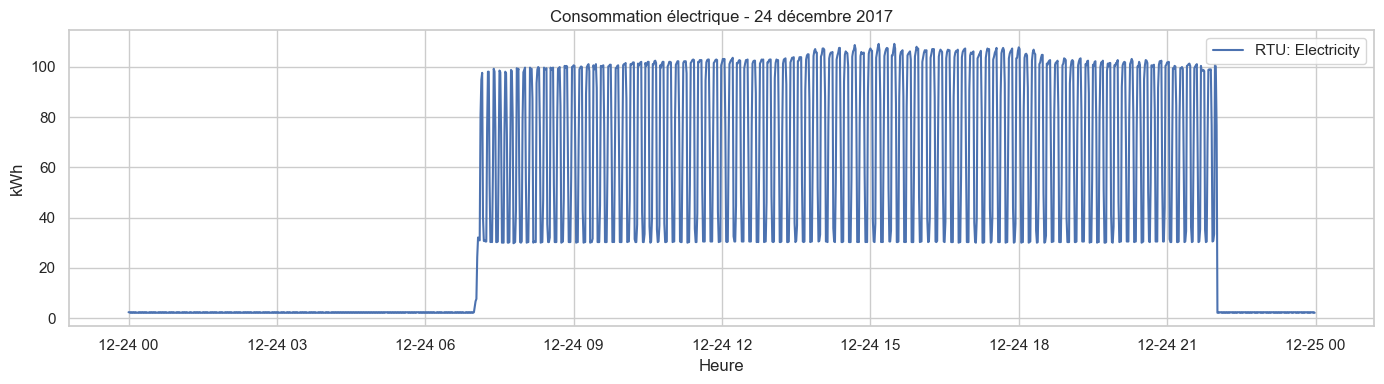

In [4]:
# --- Étape 3 : Analyse exploratoire ---
print("Dimensions après filtrage :", df.shape)
print("\nTypes de données :")
print(df.dtypes)

# Statistiques descriptives
display(df.describe().T)

# Taux de valeurs manquantes par colonne
missing_ratio = df.isnull().mean().sort_values(ascending=False) * 100
display(missing_ratio)

# Vérifier les NaN sur la variable cible
print("RTU: Electricity - valeurs manquantes :", df["RTU: Electricity"].isna().sum())

# Courbe de la consommation
plt.figure(figsize=(14, 4))
plt.plot(df["Timestamp"], df["RTU: Electricity"], label="RTU: Electricity")
plt.title("Consommation électrique - 24 décembre 2017")
plt.xlabel("Heure")
plt.ylabel("kWh")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# --- Étape 5 : Sélection et préparation des variables multivariées ---

# Colonnes sélectionnées
selected_columns = [
    "RTU: Electricity",
    "RTU: Fan Electricity ",
    "RTU: Supply Air Volumetric Flow Rate",
    "RTU: Compressor 1 On/Off Status",
    "Occupancy Mode Indicator"
]

# Extraire les données
Y = df[selected_columns].copy()

# Vérification : pas de NaN
print("Valeurs manquantes par variable :")
print(Y.isna().sum())

# (Optionnel) Normalisation par colonne pour stabiliser l’inférence
Y_norm = (Y - Y.mean()) / Y.std()

# Vérification de la structure
print("\nDimensions du vecteur Y_t :", Y_norm.shape)
Y_norm.head()


Valeurs manquantes par variable :
RTU: Electricity                          0
RTU: Fan Electricity                      0
RTU: Supply Air Volumetric Flow Rate    539
RTU: Compressor 1 On/Off Status           0
Occupancy Mode Indicator                  0
dtype: int64

Dimensions du vecteur Y_t : (1440, 5)


,RTU: Electricity,RTU: Fan Electricity,RTU: Supply Air Volumetric Flow Rate,RTU: Compressor 1 On/Off Status,Occupancy Mode Indicator
0,-1.017555,-1.286822,NaN,-0.861873,-1.29246
1,-1.017555,-1.286822,NaN,-0.861873,-1.29246
2,-1.022960,-1.286822,NaN,-0.861873,-1.29246
3,-1.017555,-1.286822,NaN,-0.861873,-1.29246
4,-1.022960,-1.286822,NaN,-0.861873,-1.29246


In [6]:
# --- Étape 5 suite : Imputation des valeurs manquantes par la moyenne ---
Y_norm_clean = Y_norm.fillna(Y_norm.mean())

# Vérification finale
print("Dimensions après imputation :", Y_norm_clean.shape)
print("Valeurs manquantes restantes :", Y_norm_clean.isna().sum().sum())  # doit être 0


Dimensions après imputation : (1440, 5)
Valeurs manquantes restantes : 0


In [7]:
import pymc as pm
import pytensor.tensor as at

# Préparation des données
#Y_vals = Y_norm_clean.values  # numpy array (1440, 5)
Y_vals = Y_norm_clean.iloc[:200].values
N, D = Y_vals.shape           # N = nb de points, D = nb de dimensions
K = 3                         # nb d'états cachés

with pm.Model() as hmm_model:

    # Moyennes des états (chaque état a un vecteur de D moyennes)
    mu = pm.Normal("mu", mu=0.0, sigma=2.0, shape=(K, D))

    # Matrice de covariance partagée ou par état (simplifiée ici : diagonale par état)
    sigma_diag = pm.Exponential("sigma_diag", lam=1.0, shape=(K, D))

    # Matrice de transition (log-probas)
    trans_matrix = pm.Dirichlet("trans_matrix", a=np.ones((K, K)), shape=(K, K))

    # Initial state distribution
    pi_0 = pm.Dirichlet("pi_0", a=np.ones(K))

    # Forward algorithm
    logp = at.zeros((N, K))

    # Log-likelihood au temps t = 0
    for k in range(K):
        obs_0 = pm.MvNormal.dist(mu[k], cov=at.diag(sigma_diag[k]))
        logp = at.set_subtensor(logp[0, k], at.log(pi_0[k]) + pm.logp(obs_0, Y_vals[0])
)

    # Forward sur t = 1 à N-1
    for t in range(1, N):
        for k in range(K):
            obs_k = pm.MvNormal.dist(mu[k], cov=at.diag(sigma_diag[k]))
            emission_logp = pm.logp(obs_k, Y_vals[t])
            trans_logp = at.log(trans_matrix[:, k])
            logp_t = logp[t - 1] + trans_logp + emission_logp
            logp = at.set_subtensor(logp[t, k], pm.math.logsumexp(logp_t))
    total_logp = pm.math.logsumexp(logp[-1])
    pm.Potential("hmm_likelihood", total_logp)


In [8]:
# --- Étape 7 : Inférence bayésienne ---
with hmm_model:
    idata = pm.sample(
        draws=100,
        tune=100,
        chains=1,
        cores=1,
        target_accept=0.9,
        progressbar=True
    )


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma_diag, trans_matrix, pi_0]


Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 179 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11356\79656894.py:52: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\ADMIN\anaconda3\envs\pymc_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


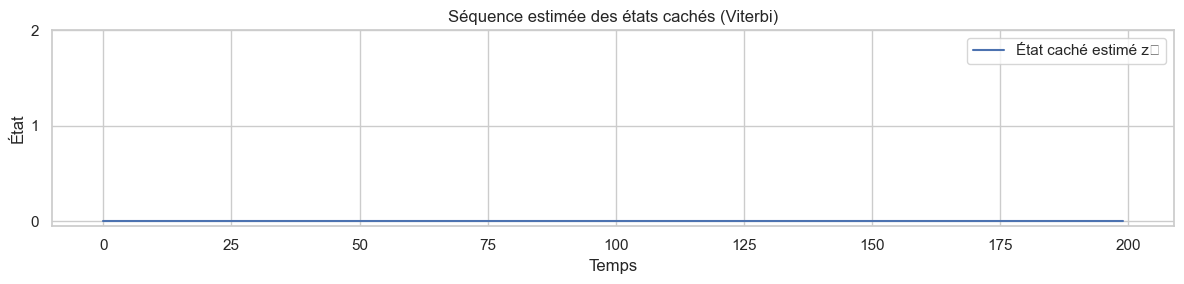

In [9]:
import numpy as np

# Récupérer les paramètres postérieurs moyens
mu_post = idata.posterior['mu'].mean(dim=["chain", "draw"]).values  # (K, D)
sigma_post = idata.posterior['sigma_diag'].mean(dim=["chain", "draw"]).values  # (K, D)
trans_post = idata.posterior['trans_matrix'].mean(dim=["chain", "draw"]).values  # (K, K)
pi_0_post = idata.posterior['pi_0'].mean(dim=["chain", "draw"]).values  # (K,)

N = Y_vals.shape[0]
K = mu_post.shape[0]

# Calcul des log-vraisemblances par état pour chaque t
log_lik = np.zeros((N, K))

for k in range(K):
    diff = Y_vals - mu_post[k]  # (N, D)
    log_det = np.sum(np.log(sigma_post[k]))
    quad_form = np.sum((diff ** 2) / sigma_post[k], axis=1)
    log_lik[:, k] = -0.5 * (log_det + quad_form + Y_vals.shape[1] * np.log(2 * np.pi))

# Viterbi : log proba max
best_logp = np.zeros((N, K))
back_ptr = np.zeros((N, K), dtype=int)

best_logp[0] = np.log(pi_0_post) + log_lik[0]

for t in range(1, N):
    for k in range(K):
        trans_probs = np.log(trans_post[:, k])
        candidates = best_logp[t - 1] + trans_probs
        best_prev = np.argmax(candidates)
        best_logp[t, k] = candidates[best_prev] + log_lik[t, k]
        back_ptr[t, k] = best_prev

# Reconstruction de la séquence d’états z_t
z_star = np.zeros(N, dtype=int)
z_star[-1] = np.argmax(best_logp[-1])
for t in reversed(range(1, N)):
    z_star[t - 1] = back_ptr[t, z_star[t]]

# Affichage simple
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(z_star, drawstyle="steps-post", label="État caché estimé zₜ")
plt.title("Séquence estimée des états cachés (Viterbi)")
plt.xlabel("Temps")
plt.ylabel("État")
plt.yticks(np.arange(K))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
